#  A2 - Clustering and Visualization - Ghazal Saheb Jam 301403311
## Part One: Gaussian Mixture Model and Visualization
External Libraries:
    1. Pandas: https://pandas.pydata.org/
    2. Sklearn: https://scikit-learn.org/stable/
    3. Numpy: https://numpy.org/
    4. Matplotlib: https://matplotlib.org/
    5. UMAP: https://umap-learn.readthedocs.io/en/latest/
    6. Seaborn: https://seaborn.pydata.org/

1. Extract frames of the videos

First extract frames of the videos by running convert.sh script. A frames directory will be created.

2. Aggregate all .csv files into one data structure. Label each row with its corresponding video file name.
Two new columns will be generated:

    1. Frame number
    2. File name

We will use this two in the future steps to find desired frames.

In [118]:
# ref: https://blog.softhints.com/how-to-merge-multiple-csv-files-with-python/

import os, glob
import pandas as pd
from sklearn.preprocessing import StandardScaler

path = "Phoebe_dataset4/single_person_au_intensity/train"

all_files = glob.glob(os.path.join(path, "*.csv"))

all_df = []
for f in all_files:
    df = pd.read_csv(f, sep=',')
    df['file'] = f.split('/')[-1]
    all_df.append(df)

merged_df = pd.concat(all_df, ignore_index=True, sort=True)


3. Prune data (preprocess)

Remove frames with low confidence (under 80 percent) and also frames with success equal to 0. Because the frames with
low confidence will cause noise and also success determines if the OpenFace could find the AUs for the face.

In [119]:
index_success =  merged_df[ merged_df[' success'] == 0 ].index
merged_df.drop(index_success , inplace=True)
index_confidence = merged_df[merged_df[' confidence'] <= .80].index
merged_df.drop(index_confidence , inplace=True)

4. Slice data to extract AUs

Since the data contains columns such as file_name, confidence, etc. Slice the final merged data to only extract columns
with AUs.

In [120]:
import matplotlib.pyplot as plt
ar = merged_df.iloc[:,0:17].to_numpy()

5. Perform GMM with BIC on data

In order to find the optimal number of components for GMM we use Bayesian information criterion(BIC) to find the optimal
number.
Since the optimal number of components change per run, I ran the program multiple times and got 9 as an optimal number.
Also prints the means and the mixing-coefficients for the GMM.

In [121]:
from sklearn import mixture
import numpy as np

lowest_bic = np.infty
bic = []
components_range  = np.arange(1,18)
optimal_n_components   = components_range[0]
optimal_gmm = None
for n_components in components_range:
    gmm = mixture.GaussianMixture(n_components=n_components,
                                  covariance_type='full')
    gmm.fit(ar)
    bic.append(gmm.bic(ar))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        optimal_n_components = n_components
        optimal_gmm = gmm
print('optimal number of components =',str(optimal_n_components))
print('GMM means:',optimal_gmm.means_)
print('GMM mixing coefficients:', optimal_gmm.weights_)

/Users/ghazals/Library/Python/3.7/lib/python/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Users/ghazals/Library/Python/3.7/lib/python/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


optimal number of components = 16
GMM means: [[1.32662106e-01 5.20909109e-02 1.07215553e+00 3.04823505e-02
  1.73462972e+00 5.21265757e-01 7.22536467e-02 1.51189916e+00
  1.69956083e+00 1.86672972e+00 1.36205113e-01 3.51842834e-01
  8.27653583e-02 6.69722089e-02 3.44690455e-01 3.09113975e-01
  5.32053640e-02]
 [8.31688836e-02 4.34708859e-02 6.76060499e-01 2.47629491e-21
  1.07689753e-18 3.06853795e-01 4.09361461e-02 1.54667853e-01
  5.25680411e-02 1.24345491e-20 1.34281536e-01 3.66895698e-01
  6.57285468e-02 7.91461937e-02 3.50252916e-01 4.93969169e-01
  2.25425970e-01]
 [1.73463799e-01 5.49472699e-02 4.47491779e-01 8.48924083e-02
  2.93952640e-04 1.90006371e-01 1.73341579e-02 1.50729956e-01
  2.44022967e-01 8.68813490e-01 1.43078261e-01 3.53826888e-01
  9.36592076e-02 3.17505808e-02 2.04311680e-01 1.55299452e-01
  2.87497201e-01]
 [1.62221043e-01 1.56970985e-01 6.23503816e-01 9.14840170e-02
  2.28972308e-01 5.06649410e-01 1.23943897e-01 4.23148543e-01
  3.62199204e-01 9.02487057e-02 6

6. Predict the probability

Predict the probability each point belongs to each cluster.
Run feature vectors through GMM to find out which has the highest likelihood for each component.
The column before the file name is the row number of each file (indexed from 0).
Finds the data with highest probability for each specific cluster and finds the corresponding file name
and frame in the main preprocessed dataframe. (i.e. 37 file 15.csv means frame 38 or row 37 of file 15.csv )

In [122]:
gmm = mixture.GaussianMixture(n_components=9, covariance_type='full').fit(ar)
probs = gmm.predict_proba(ar)
print('probabilities:\n', probs)
max_indexes = [None]*9
for i in range(0,9):
    max_indexes[i] = np.argmax(probs[:,i], axis=0)
    print('ar_max_index:\n', ar[max_indexes[i],:])
    print('merged_df:\n', merged_df.iloc[max_indexes[i],:])

probabilities:
 [[9.81504625e-004 0.00000000e+000 3.63515309e-215 ... 9.99014236e-001
  3.31878313e-013 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.41338419e-233 ... 9.99999602e-001
  1.62139871e-013 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 5.06641928e-215 ... 9.99999362e-001
  3.39669730e-013 0.00000000e+000]
 ...
 [0.00000000e+000 0.00000000e+000 1.68624127e-088 ... 0.00000000e+000
  8.73444145e-009 0.00000000e+000]
 [7.14699123e-003 0.00000000e+000 6.61486619e-093 ... 0.00000000e+000
  5.53766703e-008 0.00000000e+000]
 [5.26292723e-001 0.00000000e+000 3.10643487e-078 ... 0.00000000e+000
  4.28262881e-005 0.00000000e+000]]
ar_max_index:
 [0.44 0.02 1.04 0.   0.49 0.   0.19 1.44 1.53 2.92 0.   0.14 0.   0.
 0.36 0.06 0.05]
merged_df:
  AU01_r          0.44
 AU02_r          0.02
 AU04_r          1.04
 AU05_r             0
 AU06_r          0.49
 AU07_r             0
 AU09_r          0.19
 AU10_r          1.44
 AU12_r          1.53
 AU14_r          2.92
 AU15_r        

7. Show the image of the corresponding feature vector

frame_n = 33
file_name = 29.csv
cluster number = 1
frame_n = 53
file_name = 25.csv
cluster number = 2
frame_n = 24
file_name = 44.csv
cluster number = 3
frame_n = 52
file_name = 36.csv
cluster number = 4
frame_n = 11
file_name = 41.csv
cluster number = 5
frame_n = 17
file_name = 24.csv
cluster number = 6
frame_n = 8
file_name = 42.csv
cluster number = 7
frame_n = 72
file_name = 1.csv
cluster number = 8
frame_n = 42
file_name = 15.csv
cluster number = 9


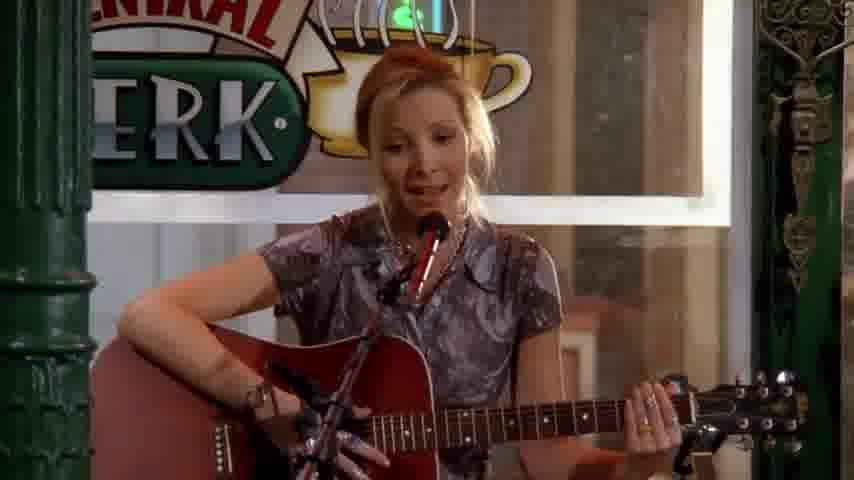

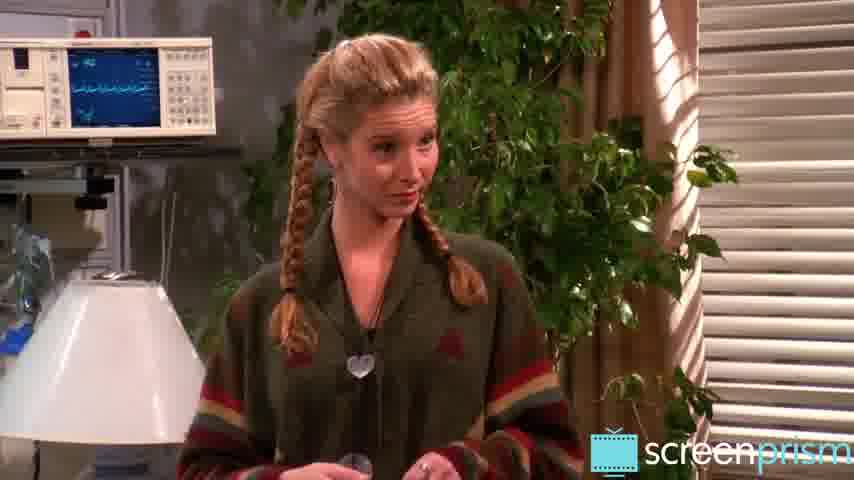

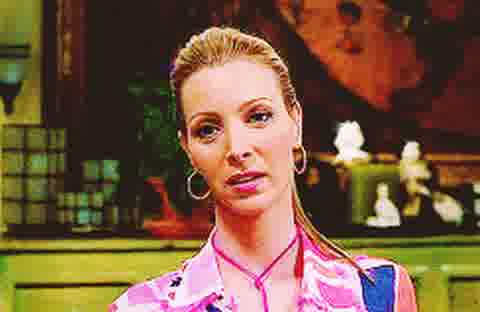

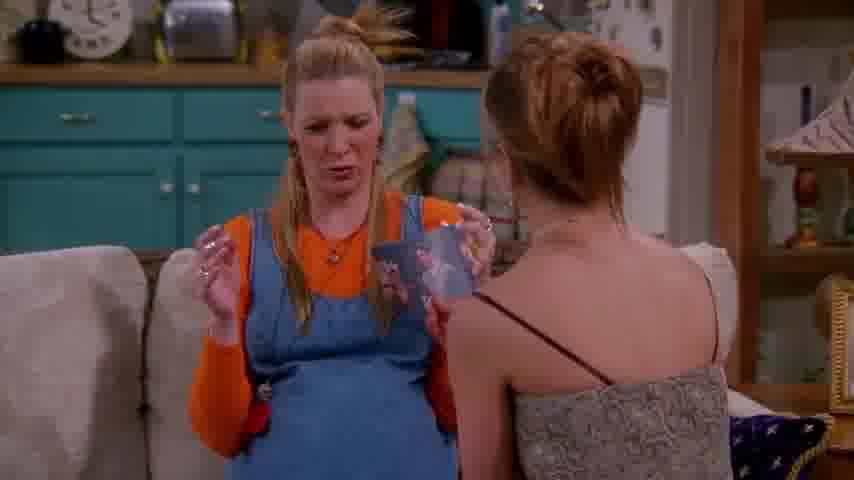

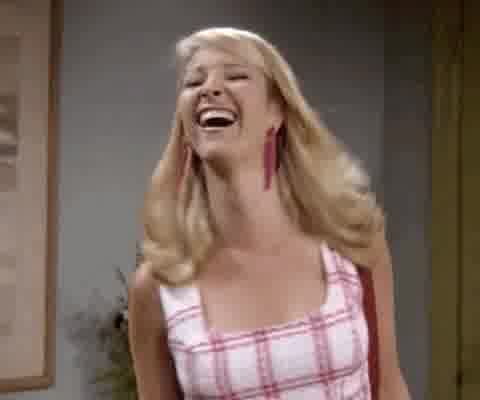

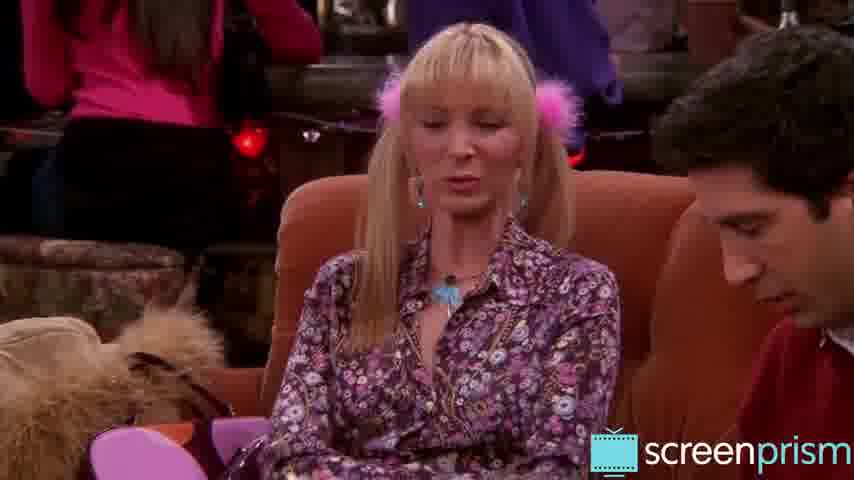

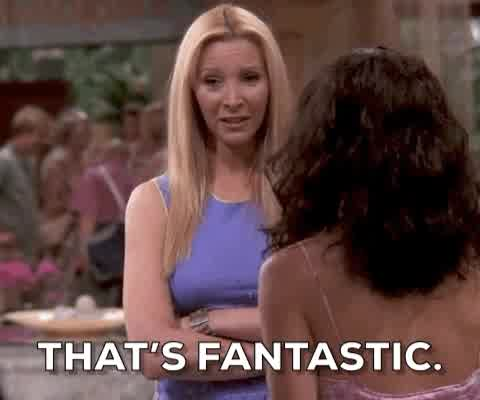

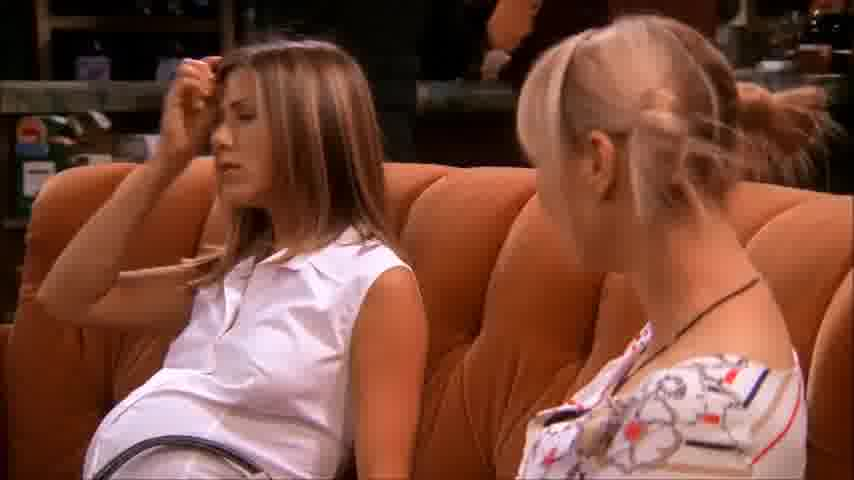

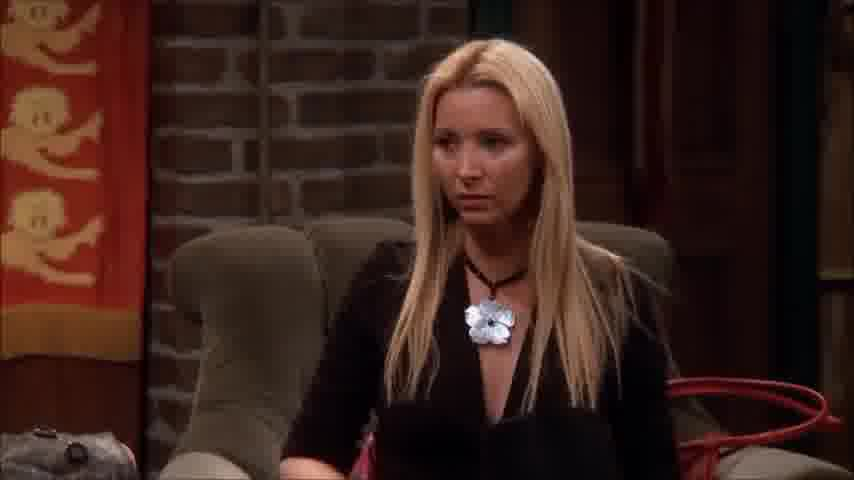

In [123]:
from IPython.display import Image, display
for i in range(0,9):
    frame_n = str(merged_df.iloc[max_indexes[i],20] + 1)
    file_name = str(merged_df.iloc[max_indexes[i],21])
    print('frame_n =', frame_n)
    print('file_name =', file_name)
    if file_name.endswith(' .csv'):
        pil_img = Image('Phoebe_dataset4/frames/Phoebe_dataset4/videos/train/'+ file_name[:-5] +
                    '.mp4/' + frame_n + '.jpeg' )
    else:
        pil_img = Image('Phoebe_dataset4/frames/Phoebe_dataset4/videos/train/'+ file_name[:-4] +
                    '.mp4/' + frame_n + '.jpeg' )
    print('cluster number =', i+1)
    display(pil_img)


I think the closest image to the mean shows the basic emotions such as happiness, surprise, sadness, etc.
For the last run I got
1 -> angry
2 -> happy
3 -> confused
4 -> interest
5 -> joy
6 -> happiness
7 -> surprise
8 -> fear
9 -> disgust
(Because every time we run this these changes maybe these are not consistent)

## Part Three - Soft Classification
Use trained model to soft-classify the 3 test videos


1. Extract images from test videos

First extract frames of the videos using convert_test.sh script. A test directory will be created inside the existing
frames directory.

2. Combine test dataFrames into one

In [124]:
path = "Phoebe_dataset4/single_person_au_intensity/test"

all_files = glob.glob(os.path.join(path, "*.csv"))

all_df = []
for f in all_files:
    df = pd.read_csv(f, sep=',')
    df['file'] = f.split('/')[-1]
    all_df.append(df)

test_df = pd.concat(all_df, ignore_index=True, sort=True)
# for testing
test_df.to_csv('test_df.csv')

3. Slice data to extract AUs

In [125]:
ar_test = test_df.iloc[:,0:17].to_numpy()


4.
Predict the probabilities of the test and print labels and probabilities for each image of the test dataset
Also examples of best and worst cases of classification. (Because every time we run this these changes maybe these are
not the best when you run them)

In general classification using only AUs is not very accurate since body pose has an important effect on the final
expressed emotion. Some extra features to use would be gaze, body pose, speech rate in video, etc. Also the context of
the video is very important in the result.
Also the dataset is partially biased because it is only trained on the facial gestures of one person. For example if the
person is very extroverted maybe the facial gestures are more exaggerated and on the other hand if the person is very
introverted perhaps the expressed emotions are limited.

probabilities:
 [[5.86166152e-004 2.40881043e-004 1.07102226e-029 7.39854012e-010
  7.83335882e-010 4.01118592e-010 4.99376635e-001 3.05679965e-009
  4.99796313e-001]
 [9.77471812e-001 0.00000000e+000 2.22949566e-002 2.24738921e-004
  2.65583598e-006 1.38351075e-007 0.00000000e+000 5.69813321e-006
  0.00000000e+000]
 [5.91929913e-001 0.00000000e+000 4.06250843e-001 1.81359914e-003
  2.20041670e-006 3.69795757e-010 0.00000000e+000 3.44331706e-006
  0.00000000e+000]
 [3.41968213e-006 7.56878366e-006 1.69407705e-007 1.65669108e-008
  1.86372825e-011 1.52239689e-019 2.35613978e-199 1.63092883e-011
  9.99988826e-001]
 [5.15585429e-006 6.42978665e-006 5.76927796e-010 3.15867837e-008
  5.60481551e-011 6.36982298e-019 1.94534995e-003 2.44986972e-011
  9.98043032e-001]
 [5.96738205e-006 6.20669908e-006 1.48788893e-012 1.21613095e-007
  1.16643368e-010 2.81300727e-020 4.55396916e-003 2.21987737e-011
  9.95433735e-001]
 [1.23173810e-005 4.37088642e-006 4.31880231e-014 2.84683579e-007
  8.31978221

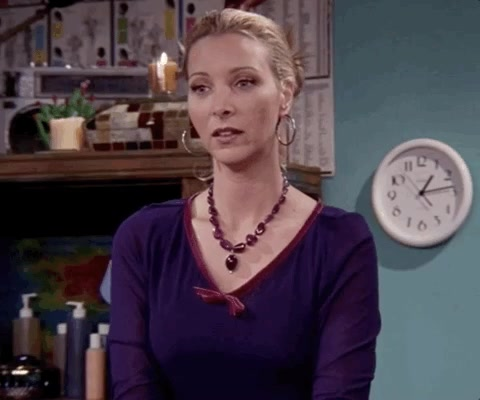

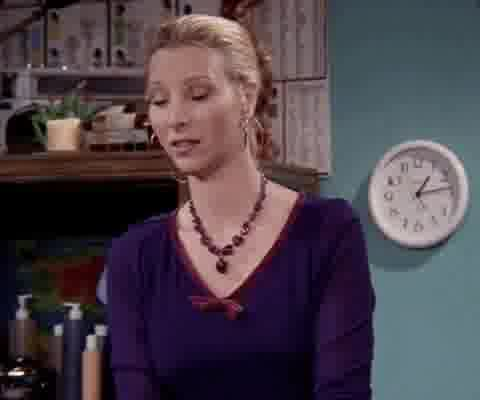

In [126]:
probs = gmm.predict_proba(ar_test)
print('probabilities:\n', probs)
labels_test = gmm.predict(ar_test)
print('labels:\n',labels_test)

frame_n_best = str(test_df.iloc[4][20])
file_name_best = str(test_df.iloc[4][21])
print(labels_test[4])
print('frame_n_best =', frame_n_best)
print('file_name_best =', file_name_best)
if file_name_best.endswith(' .csv'):
    pil_img = Image('Phoebe_dataset4/frames/Phoebe_dataset4/videos/test/'+ file_name_best[:-5] +
                '.mp4/' + frame_n_best + '.jpeg' )
else:
    pil_img = Image('Phoebe_dataset4/frames/Phoebe_dataset4/videos/test/'+ file_name_best[:-4] +
                '.mp4/' + frame_n_best + '.jpeg' )
display(pil_img)

frame_n_worst = str(test_df.iloc[40][20])
file_name_worst = str(test_df.iloc[40][21])
print(labels_test[40])
print('frame_n_worst =', frame_n_worst)
print('file_name_worst =', file_name_best)
if file_name_worst.endswith(' .csv'):
    pil_img = Image('Phoebe_dataset4/frames/Phoebe_dataset4/videos/test/'+ file_name_worst[:-5] +
                '.mp4/' + frame_n_worst + '.jpeg' )
else:
    pil_img = Image('Phoebe_dataset4/frames/Phoebe_dataset4/videos/test/'+ file_name_worst[:-4] +
                '.mp4/' + frame_n_worst + '.jpeg' )
display(pil_img)

## Part Two - Dimensionality Reduction

1.
Start applying UMAP to the data


In [127]:
import umap
reducer = umap.UMAP()
scaled_data = StandardScaler().fit_transform(merged_df.iloc[:,0:17].to_numpy())
embedding = reducer.fit_transform(scaled_data)
print(embedding.shape)

(3110, 2)


2.
Plot the reduced original data

Text(0.5, 1.0, 'UMAP projection of the friends dataset')

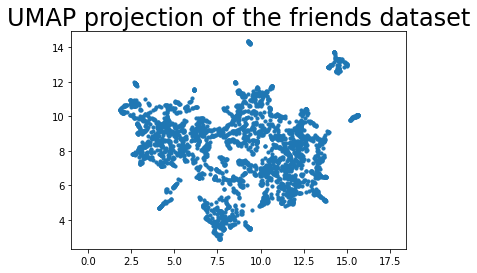

In [128]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s = 10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the friends dataset', fontsize=24)


3.
Apply the GMM from (1) again to the data, in this reduced feature space, again optimizing the number of components using BIC.

In [129]:
lowest_bic = np.infty
bic = []
components_range  = np.arange(1,17)
optimal_n_components   = components_range[0]
optimal_gmm = None
for n_components in components_range:
    gmm = mixture.GaussianMixture(n_components=n_components,
                                  covariance_type='full')
    gmm.fit(embedding)
    bic.append(gmm.bic(embedding))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        optimal_n_components = n_components
        optimal_gmm = gmm
print('optimal number of components =',str(optimal_n_components))
print('GMM means:',optimal_gmm.means_)
print('GMM mixing coefficients:', optimal_gmm.weights_)

optimal number of components = 16
GMM means: [[ 4.56525484  9.47194034]
 [11.72807562  5.66591597]
 [12.35542926  9.23145169]
 [ 4.37604733  8.0048425 ]
 [ 8.81933172  6.74184643]
 [ 7.81733347  4.09935711]
 [ 4.57943859  5.34522572]
 [14.43637511 13.07912936]
 [10.02389253 10.26103223]
 [13.41213083  7.13766401]
 [11.60164973  7.63413785]
 [ 2.69786915 10.36908667]
 [15.47094485  9.98462253]
 [ 6.47503468  8.68041174]
 [ 8.62268754  9.4046147 ]
 [10.24185857  5.93572463]]
GMM mixing coefficients: [0.09080345 0.04856836 0.04682535 0.08875287 0.07353063 0.08616473
 0.01827826 0.03151108 0.10352209 0.06225741 0.09499407 0.05325191
 0.01575563 0.0685089  0.08478396 0.03249131]


Because of the noise that data reduction causes it will recognize extra clusters and the optimal number of clusters it
gives us is 13.

Predict labels for data.

In [130]:
gmm = mixture.GaussianMixture(n_components=13).fit(embedding)
labels = optimal_gmm.predict(embedding)
print(labels)

[3 3 3 ... 3 3 3]


Plot the results(It takes a while)


Text(0.5, 1.0, 'UMAP projection of the friends dataset')

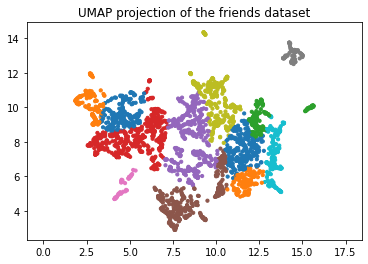

In [131]:
import seaborn as sns
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette(None,len(labels))[x] for x in labels],
    s = 10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the friends dataset')

By inspecting the corresponding images that GMM + UMAP classified, we can see that images does not match with the categories
in GMM one, it appears that sub categories are considered as categories (layperson's view).
Not all of the smiles fall into one category in the UMAP because it is more noisy and outputs more categories so
big smiles(wide lips) are classified differently from smiles like contempt.